# Post Processing Pipeline

Code below lets you read in the raw output from the simulation and recombine the images from multiple processors

In [14]:
# Dependencies
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from PIL import Image

In [15]:
# User specified parameters

directory = "./dats/out_periodic_parallel_8" # directory where the output files are stored
out_directory = "./out_combined" # directory where the combined images will be stored, can be none
start_time = 0
end_time = 300 # end time for the simulation
gif_name = "Combined_Animation.gif" # name of the gif file

/tmp/ipykernel_418094/4040739442.py:78: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')


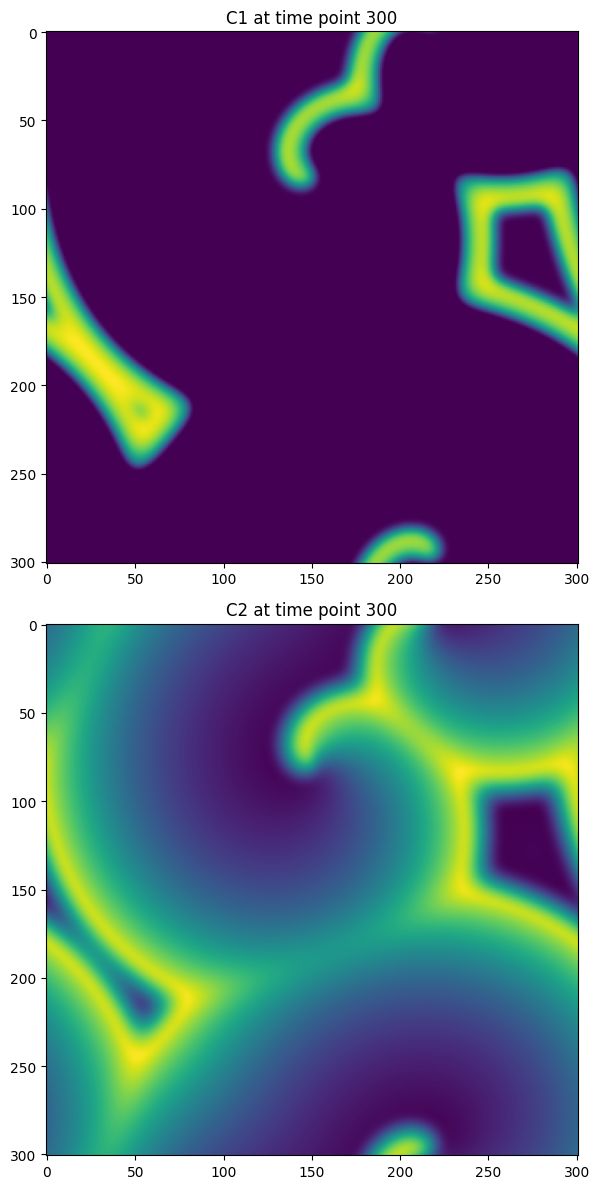

In [18]:
# Code to generate an animation
# Was generated using ChatGPT: https://chat.openai.com/share/1a058874-b674-46fa-bcec-ba9a846b5a80

def get_filenames(directory, out, type_):
    filenames = []
    for filename in os.listdir(directory):
        if filename.endswith(f"_{type_}_{out}.dat"):
            filenames.append(filename)
    return filenames

def read_file(filepath):
    with open(filepath, 'r') as file:
        lines = file.readlines()
    data = [line.strip().split('\t') for line in lines]
    return np.array(data, dtype=float)

def combine_images(directory, out, type_):
    sub_images = {}
    max_row = max_col = 0

    filenames = get_filenames(directory, out, type_)

    for filename in filenames:
        parts = filename.split('_')
        id_row = int(parts[0])
        id_col = int(parts[1])
        filepath = os.path.join(directory, filename)
        sub_images[(id_row, id_col)] = read_file(filepath)
        max_row = max(max_row, id_row)
        max_col = max(max_col, id_col)

    total_rows = sum(sub_images[(i, 0)].shape[0] for i in range(max_row + 1))
    total_cols = sum(sub_images[(0, j)].shape[1] for j in range(max_col + 1))

    combined_image = np.zeros((total_rows, total_cols))

    current_row = 0
    for i in range(max_row + 1):
        current_col = 0
        row_height = sub_images[(i, 0)].shape[0]
        for j in range(max_col + 1):
            col_width = sub_images[(i, j)].shape[1]
            combined_image[current_row:current_row + row_height, current_col:current_col + col_width] = sub_images[(i, j)]
            current_col += col_width
        current_row += row_height

    return combined_image

def save_combined_image(image, out, type_, out_directory):
    if not os.path.exists(out_directory):
        os.makedirs(out_directory)
    output_filename = os.path.join(out_directory, f"output_{type_}_{out}.png")
    plt.imsave(output_filename, image, cmap='viridis')

def generate_animation_from_raw(directory, start_time, end_time, gif_name, out_directory=None):
    fig, axs = plt.subplots(2, 1, figsize=(10, 12))
    images = []

    for out in range(start_time, end_time + 1):
        combined_image_C1 = combine_images(directory, out, "C1")
        combined_image_C2 = combine_images(directory, out, "C2")

        if out_directory:
            save_combined_image(combined_image_C1, out, "C1", out_directory)
            save_combined_image(combined_image_C2, out, "C2", out_directory)

        axs[0].clear()
        axs[0].imshow(combined_image_C1, cmap='viridis')
        axs[0].set_title(f'C1 at time point {out}')

        axs[1].clear()
        axs[1].imshow(combined_image_C2, cmap='viridis')
        axs[1].set_title(f'C2 at time point {out}')

        plt.tight_layout()

        fig.canvas.draw()
        image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
        image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        images.append(Image.fromarray(image))
        
    # Save the images as a GIF
    images[0].save(gif_name, save_all=True, append_images=images[1:], duration=100, loop=0)

    plt.show()

# Generating the animation
generate_animation_from_raw(directory, start_time, end_time, gif_name, out_directory)